In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import nibabel as nib
from scipy import ndimage
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [ ]:
# os.makedirs("/content/drive/MyDrive/project_data/imageTs")
# with zipfile.ZipFile("/content/drive/MyDrive/project_data/imagesTs.zip", "r") as z_fp:
#     z_fp.extractall("/content/drive/MyDrive/project_data/imagesTs")

# with zipfile.ZipFile("/content/drive/MyDrive/project_data/LA-labelsTs.zip", "r") as z_fp:
#     z_fp.extractall("/content/drive/MyDrive/project_data/LA-labelsTs")

# with zipfile.ZipFile("/content/drive/MyDrive/project_data/LV-labelsTs.zip", "r") as z_fp:
#     z_fp.extractall("/content/drive/MyDrive/project_data/LV-labelsTs")

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
HU_MIN = -2000
HU_MAX = 2000
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata().astype(np.int16)
    return scan

def normalize(input_volume):
    """Normalize the volume"""
    input_volume[input_volume < HU_MIN] = HU_MIN
    input_volume[input_volume > HU_MAX] = HU_MAX
    input_volume = (input_volume - HU_MIN) / (HU_MAX - HU_MIN)
    input_volume = input_volume.astype(np.float32)
    return input_volume

def resize(input_volume, target_size=(128, 128, 64), is_mask=False):
    """Resize across z-axis"""
    zoom_factors = [target_size[i] / input_volume.shape[i] for i in range(3)]
    if is_mask:
      input_volume = ndimage.zoom(input_volume, zoom_factors, order=0) # nearest neighbor
    else:
      input_volume = ndimage.zoom(input_volume, zoom_factors, order=1) # linear interp
    return input_volume

def rotate(input_volume):
    """Rotate the volume by 90 degrees"""
    input_volume = np.rot90(input_volume)
    return input_volume

def process_scan(path):
    """Read and resize volume"""
    input_volume = read_nifti_file(path)
    input_volume = normalize(input_volume)
    input_volume = resize(input_volume, is_mask=False)
    input_volume = rotate(input_volume)
    return input_volume

def process_mask(path):
    """Read and resize volume"""
    input_volume = read_nifti_file(path)
    input_volume = resize(input_volume, is_mask=True)
    input_volume = rotate(input_volume)
    return input_volume

In [ ]:
def load_image(image_path, la_label_path, lv_label_path):
    input_image = process_scan(image_path)
    la_mask = process_mask(la_label_path)
    lv_mask = process_mask(lv_label_path)
    input_mask = np.zeros(input_image.shape, dtype=np.uint8)
    input_mask[la_mask>0] = 1
    input_mask[lv_mask>0] = 2
    return input_image, input_mask

In [2]:
import glob
ed_images_paths = glob.glob('/content/drive/MyDrive/project_data/raw_data/imagesTs/*ED.nii.gz')
es_images_paths = glob.glob('/content/drive/MyDrive/project_data/raw_data/imagesTs/*ES.nii.gz')

In [3]:
images_paths = np.concatenate((ed_images_paths, es_images_paths), axis=0)

In [11]:
 max_vals = []
 min_vals = []
 for image_path in images_paths:
   image = read_nifti_file(image_path)
   max_vals.append(np.max(image))
   min_vals.append(np.min(image))

In [14]:
min_vals = np.array(min_vals)
max_vals = np.array(max_vals)

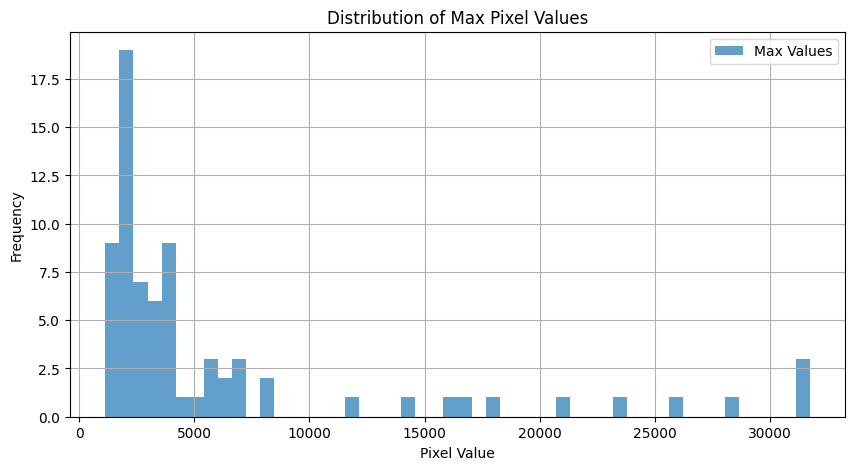

In [17]:
# prompt: generate a plot for min and max distribution

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
# plt.hist(min_vals, bins=50, alpha=0.7, label='Min Values')
plt.hist(max_vals, bins=50, alpha=0.7, label='Max Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Max Pixel Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ed_images = []
es_images = []
ed_masks = []
es_masks = []
for image_path in ed_images_paths:
  la_label_path = image_path.replace('imagesTs', 'LA-labelsTs')
  lv_label_path = image_path.replace('imagesTs', 'LV-labelsTs')
  input_image, input_mask = load_image(image_path, la_label_path, lv_label_path)
  ed_images.append(input_image)
  ed_masks.append(input_mask)

for image_path in es_images_paths:
  la_label_path = image_path.replace('imagesTs', 'LA-labelsTs')
  lv_label_path = image_path.replace('imagesTs', 'LV-labelsTs')
  input_image, input_mask = load_image(image_path, la_label_path, lv_label_path)
  es_images.append(input_image)
  es_masks.append(input_mask)

In [ ]:
ed_images = np.array(ed_images)
ed_masks = np.array(ed_masks)
es_images = np.array(es_images)
es_masks = np.array(es_masks)

In [ ]:
ed_images.shape, ed_masks.shape

((37, 128, 128, 64), (37, 128, 128, 64))

In [ ]:
images = np.concatenate((ed_images, es_images), axis=0)
masks = np.concatenate((ed_masks, es_masks), axis=0)

In [ ]:
images.shape, masks.shape

((74, 128, 128, 64), (74, 128, 128, 64))

In [ ]:
def display(image, mask):
  row = 3
  col = 6

  slices = np.arange(25, 43)

  plt.figure(figsize=(16, 8))
  for i, idx in enumerate(slices):
    plt.subplot(row, col, i+1)
    plt.imshow(image[:,:,idx], cmap='gray')
    mask_slice = mask[:,:,idx]
    masked_labels = np.ma.masked_where(mask_slice == 0, mask_slice)
    plt.imshow(masked_labels, alpha=0.5)
    plt.title(str(idx+1))
    plt.axis('off')
  plt.subplots_adjust(wspace=0.05, hspace=0.2)
  plt.show()

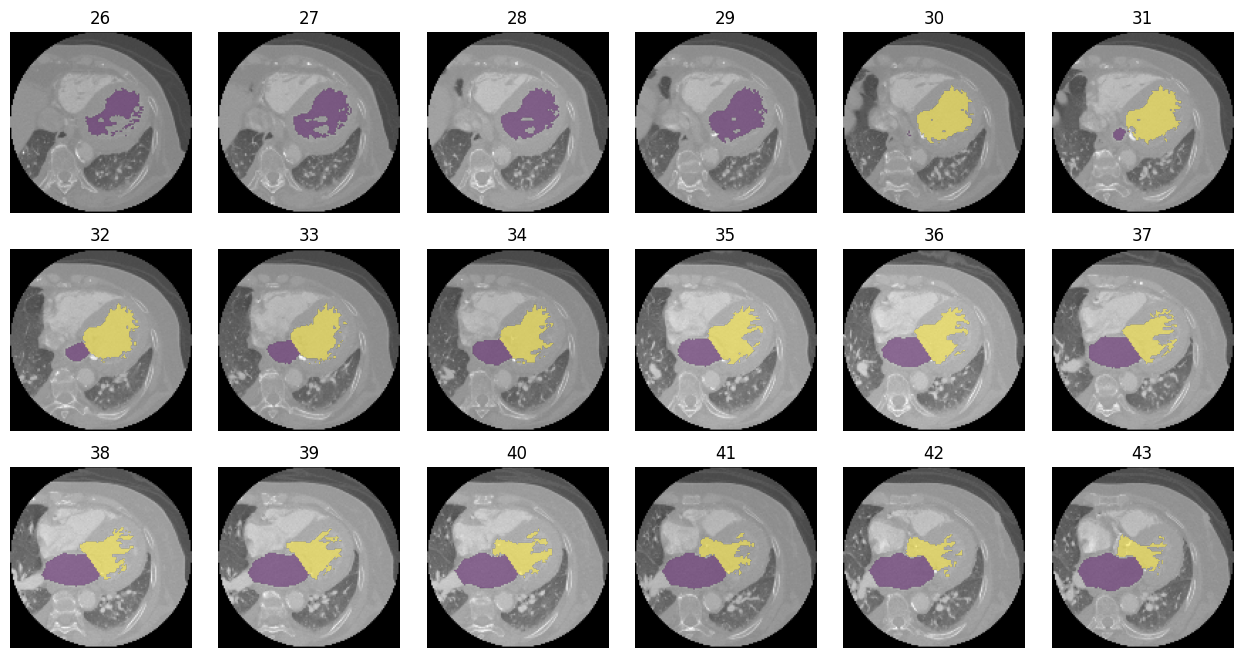

In [ ]:
display(images[0], masks[0])

# Define the model

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv3D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_stack = [
    downsample(64, 4, apply_batchnorm=False),   # 128->64
    downsample(128, 4),                         # 64->32
    downsample(256, 4),                         # 32->16
    downsample(512, 4),                         # 16->8
    downsample(512, 4)                         # 8->4
]

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv3DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_stack = [
    upsample(512, 4, apply_dropout=True),       # 4->8
    upsample(512, 4),                          # 8->16
    upsample(256, 4),                           # 16->32
    upsample(128, 4),                           # 32->64
    upsample(64, 4)                            # 64->128
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 64, 3])

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv3DTranspose(
      filters=output_channels,
      kernel_size=4,
      strides=2,
      padding='same')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Dual phased vs ED alone vs ES alone

In [ ]:
dual_phased = 0
ed = 0
es = 1

In [ ]:
if dual_phased:
  X_train, X_test, y_train, y_test = train_test_split(
    images, masks, test_size=0.5, random_state=42)
elif ed:
  X_train = ed_images
  X_test = es_images
  y_train = ed_masks
  y_test = es_masks
else:
  X_train = es_images
  X_test = ed_images
  y_train = es_masks
  y_test = ed_masks

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37, 128, 128, 64),
 (37, 128, 128, 64),
 (37, 128, 128, 64),
 (37, 128, 128, 64))

In [ ]:
# def rotate(volume):
#     """Rotate the volume by a few degrees"""
#     np.random.seed(42)
#     def scipy_rotate(volume):
#         # define some rotation angles
#         angles = [-20, -10, -5, 5, 10, 20]
#         # pick angles at random
#         angle = np.random.choice(angles)
#         # rotate volume
#         volume = ndimage.rotate(volume, angle, reshape=False)
#         volume[volume < 0] = 0
#         volume[volume > 1] = 1
#         return volume

#     augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
#     return augmented_volume

def augment(volume, label, angle_range=(-5, 5)):
    """
    Rotate with continuous angle range
    """
    np.random.seed(42)
    def scipy_rotate_continuous(volume_np, label_np):
        # volume_np = np.nan_to_num(volume_np, nan=0.0, posinf=1.0, neginf=0.0)
        # label_np = np.nan_to_num(label_np, nan=0, posinf=2, neginf=0)
        # Random angle from continuous range
        angle = np.random.uniform(angle_range[0], angle_range[1])

        # Rotate both with same angle using scipy on NumPy arrays
        rotated_volume = ndimage.rotate(volume_np, angle, reshape=False, order=1)
        rotated_label = ndimage.rotate(label_np, angle, reshape=False, order=0)

        # Post-process
        rotated_volume = np.clip(rotated_volume, 0, 1)
        # rotated_label = np.round(rotated_label).astype(label_np.dtype)
        # rotated_label = np.clip(rotated_label, 0, 2)

        return rotated_volume, rotated_label

    augmented_volume, augmented_label = tf.numpy_function(
        scipy_rotate_continuous,
        [volume, label],
        [tf.float32, tf.uint8]
    )
    # Set the shape of the output tensors from numpy_function
    augmented_volume.set_shape([128, 128, 64])
    augmented_label.set_shape([128, 128, 64])

    return augmented_volume, augmented_label

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    augmented_volume, augmented_label = augment(volume, label)
    # Add channel
    augmented_volume = tf.stack((augmented_volume,)*3, axis=-1)
    # augmented_label = tf.keras.utils.to_categorical(augmented_label, num_classes=3)
    return augmented_volume, augmented_label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    augmented_volume = tf.stack((volume,)*3, axis=-1)
    augmented_label = label
    # augmented_label = tf.keras.utils.to_categorical(augmented_label, num_classes=3)
    return augmented_volume, augmented_label

In [ ]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
# Augment the on the fly during training.
train_batches = (
    train_loader
    .cache()
    .shuffle(BUFFER_SIZE)
    .map(train_preprocessing)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# Only rescale.
test_batches = (
    test_loader
    .map(test_preprocessing)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
train_batches.element_spec

(TensorSpec(shape=(None, 128, 128, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 64), dtype=tf.uint8, name=None))

In [ ]:
test_batches.element_spec

(TensorSpec(shape=(None, 128, 128, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 64), dtype=tf.uint8, name=None))

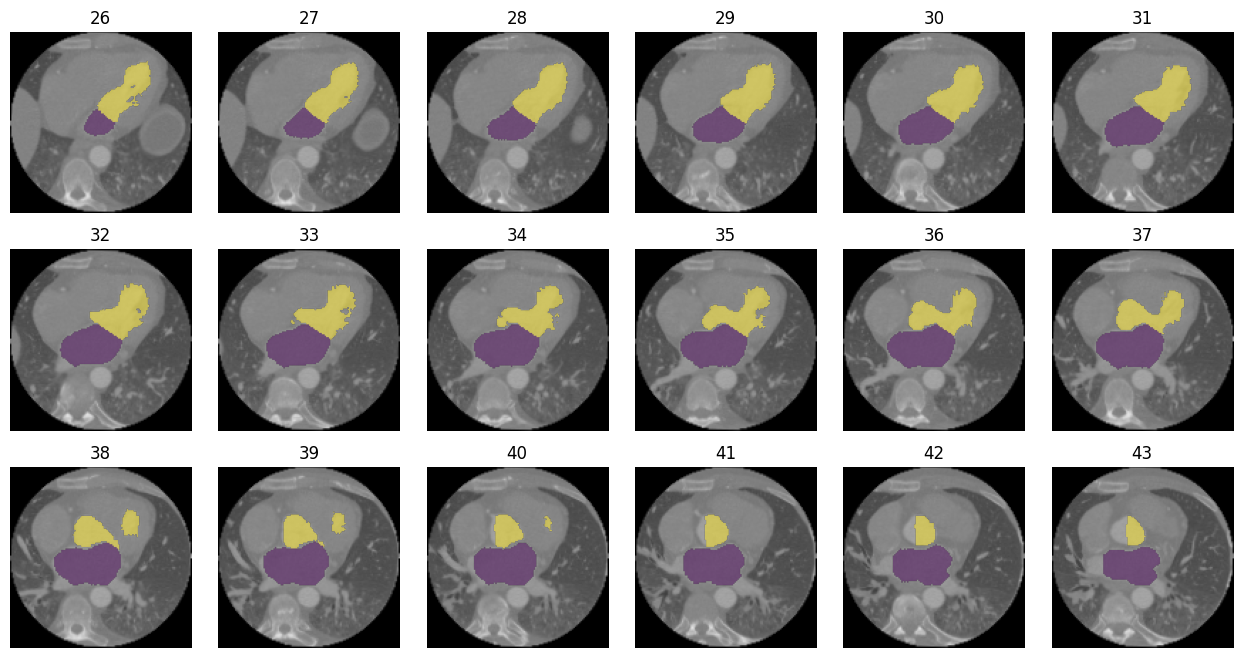

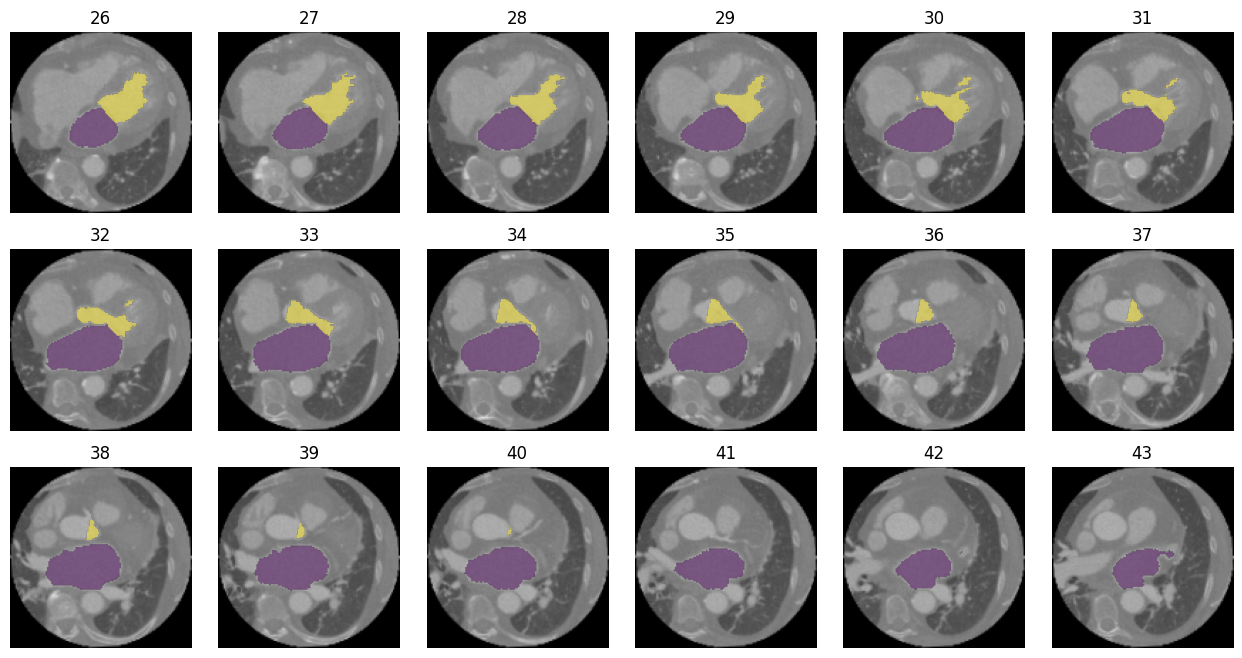

In [ ]:
for sample_images, sample_masks in train_batches.take(2):
  sample_image, sample_mask = sample_images[0], sample_masks[0]
  display(sample_image, sample_mask)

# Train the model


In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 2.0, 2.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
OUTPUT_CLASSES = 3

weighted_model = unet_model(OUTPUT_CLASSES)
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.96
)
weighted_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
# weighted_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
#     loss=tf.keras.losses.Dice(),
#     metrics=['accuracy'])

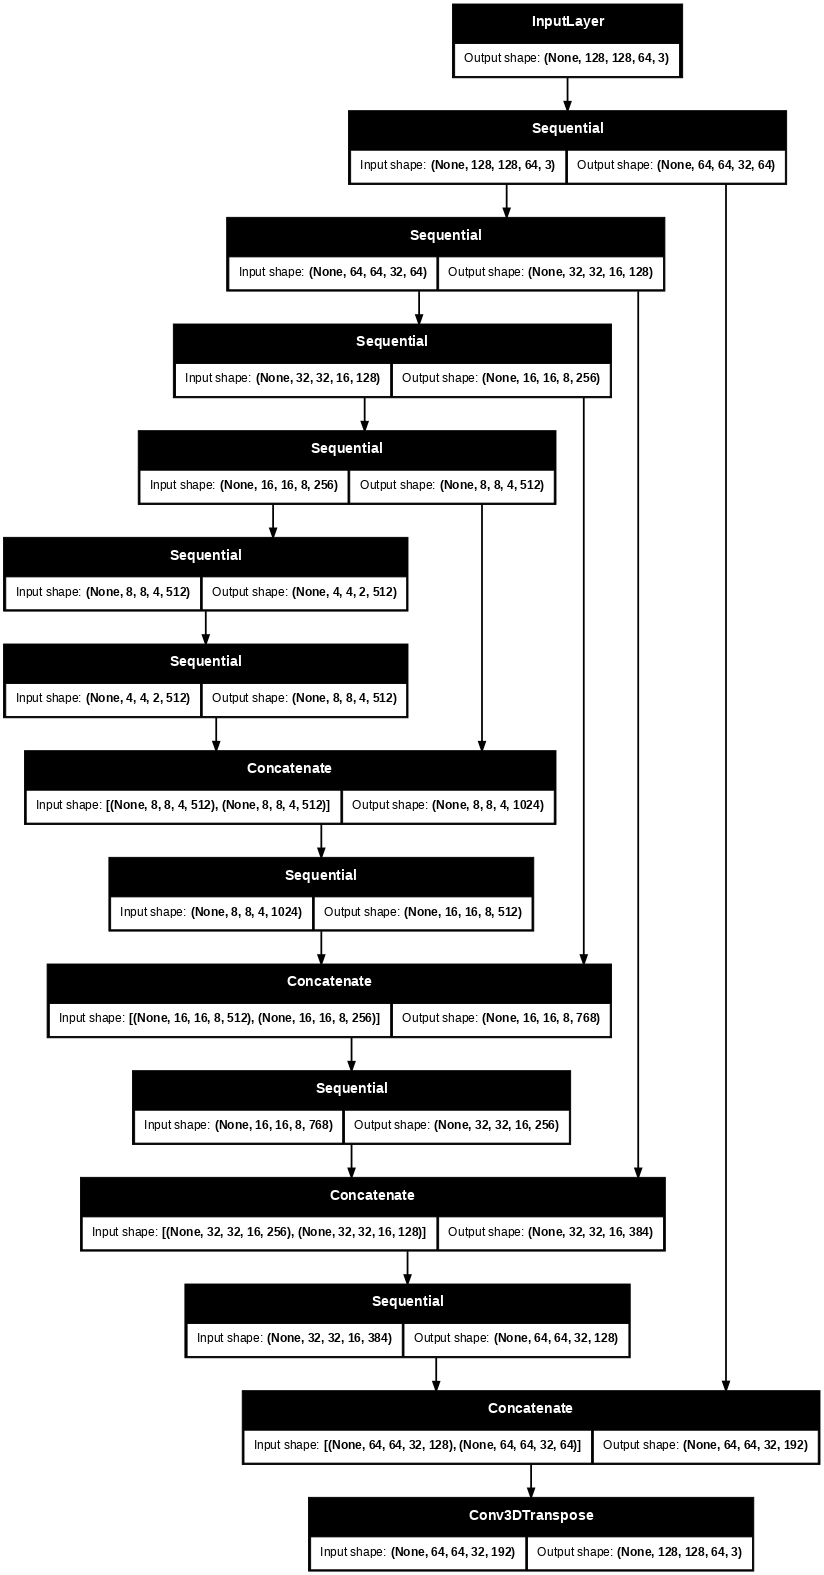

In [ ]:
tf.keras.utils.plot_model(weighted_model, show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
print(weighted_model.summary())

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │     12,288 │ input_layer_12[0… │
│ (Sequential)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    524,800 │ sequential[3][0]  │
│ (Sequential)        │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16, 8, │  2,098,176 │ sequential_1[3][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 4,   │  8,390,656 │ sequential_2[3][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4, 2,   │ 16,779,264 │ sequential_3[3][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 8, 8, 4,   │ 16,779,264 │ sequential_4[3][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 8, 8, 4,   │          0 │ sequential_5[3][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[3][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 16, 16, 8, │ 33,556,480 │ concatenate_12[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 16, 16, 8, │          0 │ sequential_6[3][… │
│ (Concatenate)       │ 768)              │            │ sequential_2[3][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 32, 32,    │ 12,583,936 │ concatenate_13[0… │
│ (Sequential)        │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 32, 32,    │          0 │ sequential_7[3][… │
│ (Concatenate)       │ 16, 384)          │            │ sequential_1[3][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64, 64,    │  3,146,240 │ concatenate_14[0… │
│ (Sequential)        │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 64, 64,    │          0 │ sequential_8[3][… │
│ (Concatenate)       │ 32, 192)          │            │ sequential[3][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_8  │ (None, 128, 128,  │     36,867 │ concatenate_15[0… │
│ (Conv3DTranspose)   │ 64, 3)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 281,712,650 (1.05 GB)

 Trainable params: 93,902,339 (358.21 MB)

 Non-trainable params: 5,632 (22.00 KB)

 Optimizer params: 187,804,679 (716.42 MB)

None


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  return pred_mask[0]

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    display(sample_image, sample_mask)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

weighted_model_history = weighted_model.fit(train_batches.map(add_sample_weights),
                                            epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_steps=VALIDATION_STEPS,
                                            validation_data=test_batches)

# weighted_model.fit(
#     train_batches.map(add_sample_weights),
#     epochs=1,
#     steps_per_epoch=10)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.7482 - loss: 0.1604 - val_accuracy: 0.9709 - val_loss: 0.2499
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9778 - loss: 0.0407 - val_accuracy: 0.9737 - val_loss: 0.1226
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.9805 - loss: 0.0234 - val_accuracy: 0.9835 - val_loss: 0.0843
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - accuracy: 0.9908 - loss: 0.0157 - val_accuracy: 0.9892 - val_loss: 0.0665
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.9935 - loss: 0.0122 - val_accuracy: 0.9907 - val_loss: 0.0531
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.9937 - loss: 0.0106 - val_accuracy: 0.9897 - val_loss: 0.0508
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.9945 - loss: 0.0084 - val_accuracy: 0.9917 - val_loss: 0.0391
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.9947 - loss: 0.0075 - val_accuracy: 0.

In [ ]:
weighted_model.save('/content/drive/MyDrive/project_data/my_model_es.h5')

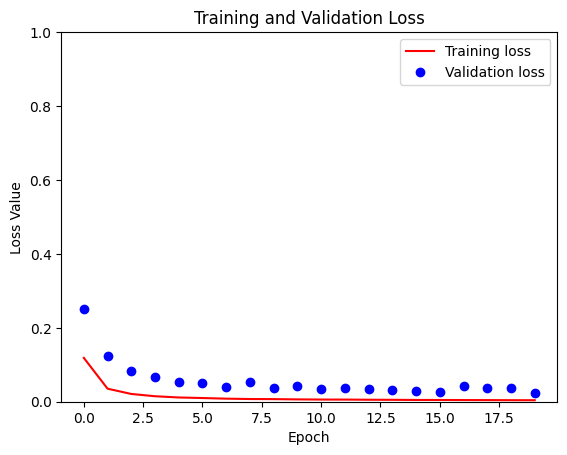

In [ ]:
loss = weighted_model_history.history['loss']
val_loss = weighted_model_history.history['val_loss']

plt.figure()
plt.plot(weighted_model_history.epoch, loss, 'r', label='Training loss')
plt.plot(weighted_model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

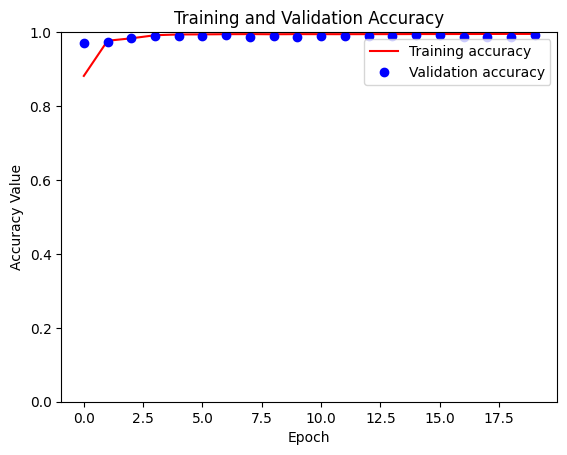

In [ ]:
acc = weighted_model_history.history['accuracy']
val_acc = weighted_model_history.history['val_accuracy']

plt.figure()
plt.plot(weighted_model_history.epoch, acc, 'r', label='Training accuracy')
plt.plot(weighted_model_history.epoch, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def show_predictions(dataset, num=1):
  for image, mask in dataset.take(num):
    pred_mask = weighted_model.predict(image)
    display(image[0][:,:,:,0], mask[0])
    display(image[0][:,:,:,0], create_mask(pred_mask))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


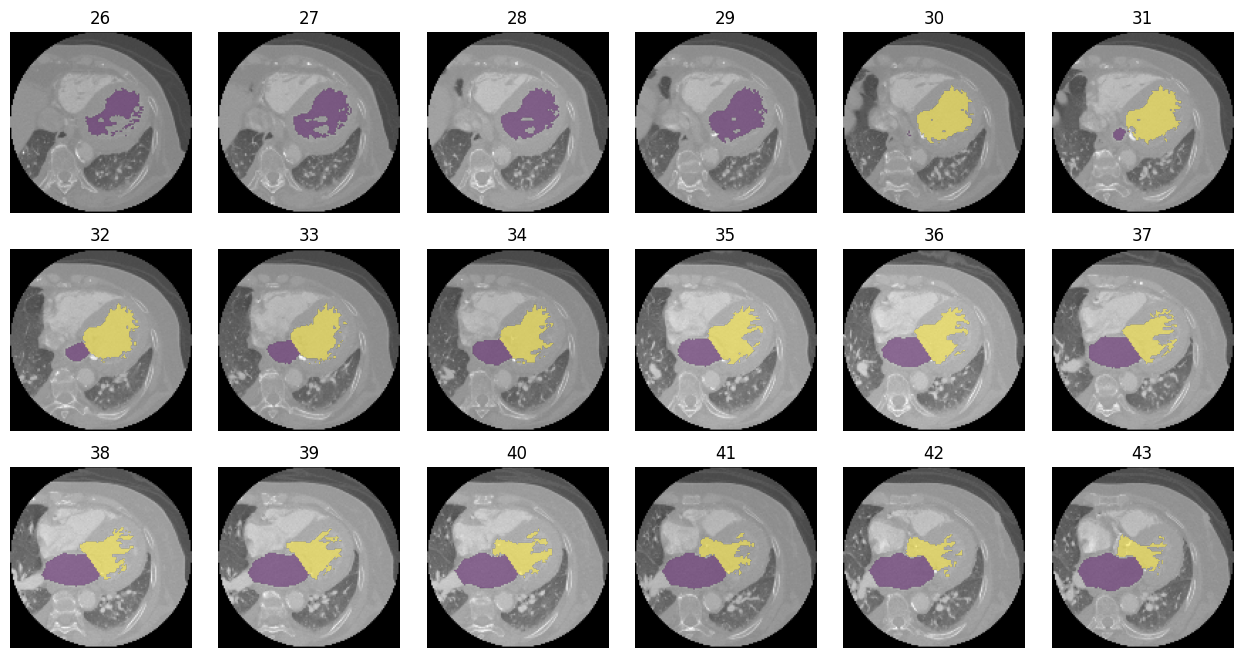

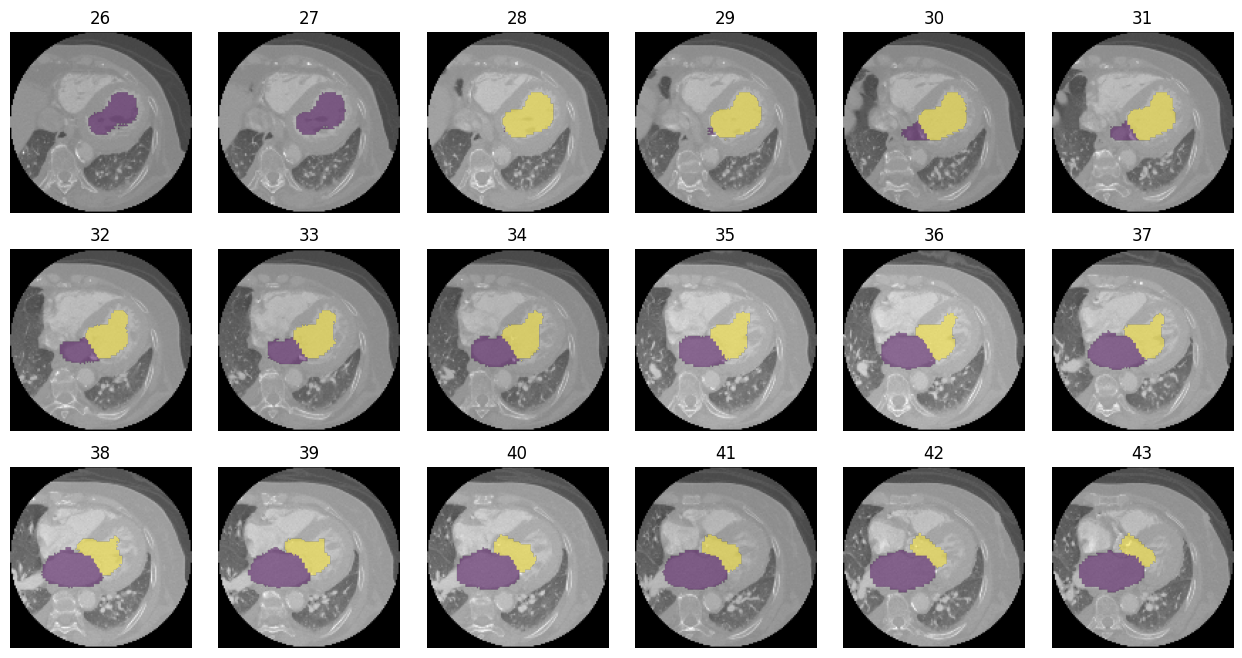

In [ ]:
show_predictions(test_batches,1)

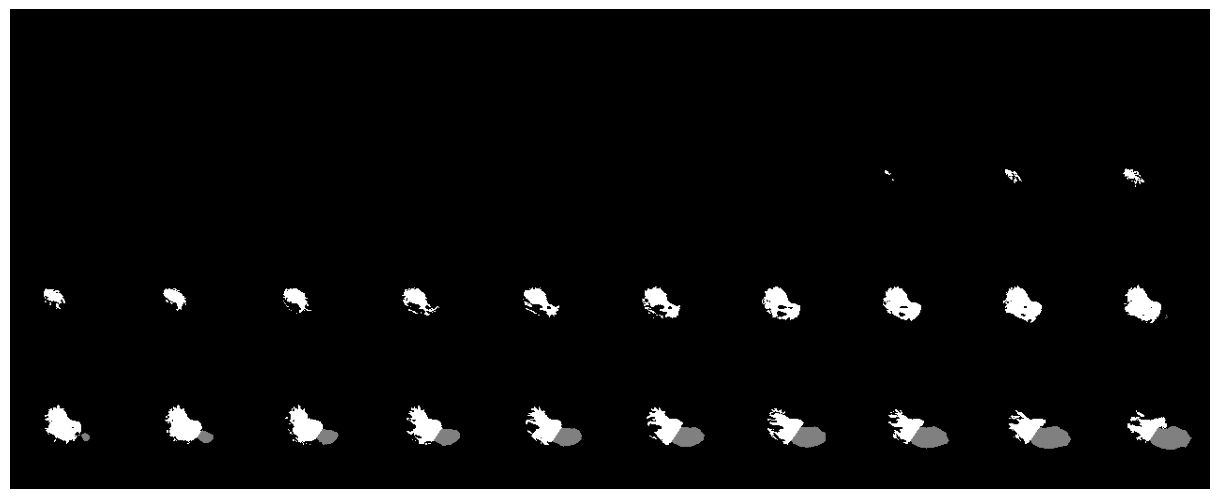

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, masks[0][:, :, :40])

In [ ]:
for image, mask in test_batches.take(1):
  pred_mask = weighted_model.predict(image)
  pred_mask = create_mask(pred_mask)
  print(pred_mask.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
(128, 128, 64)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


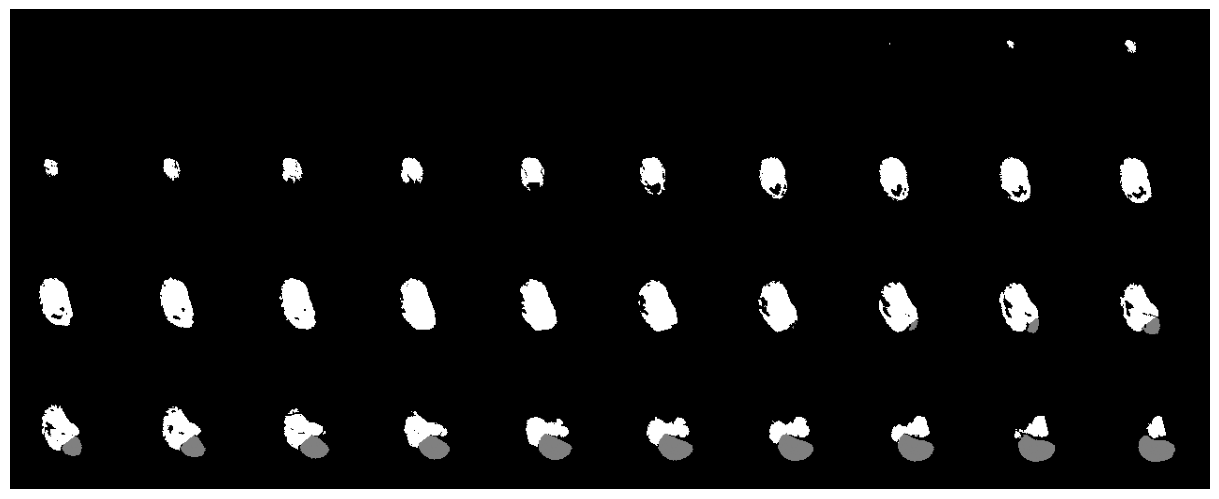

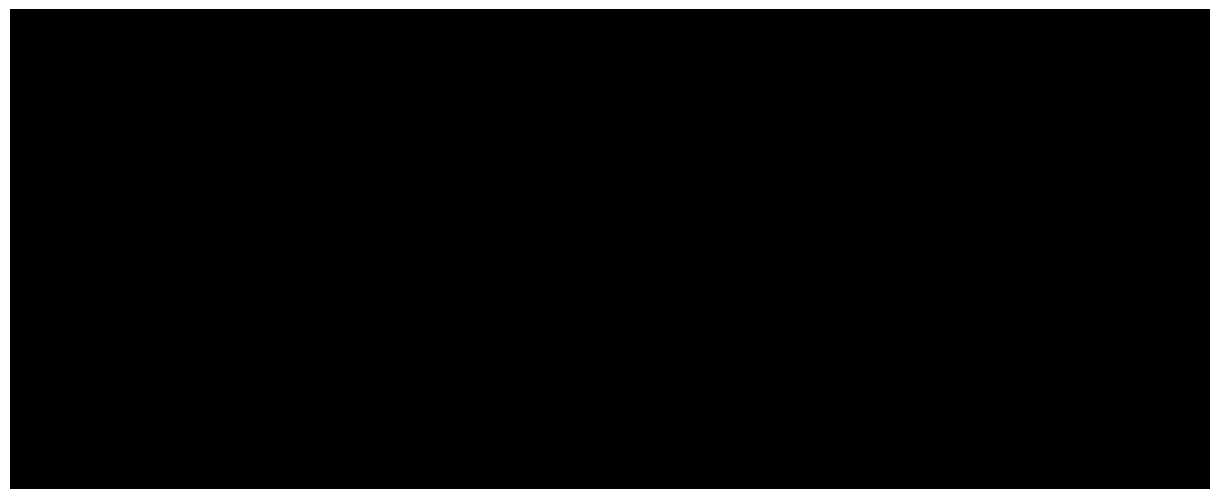

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


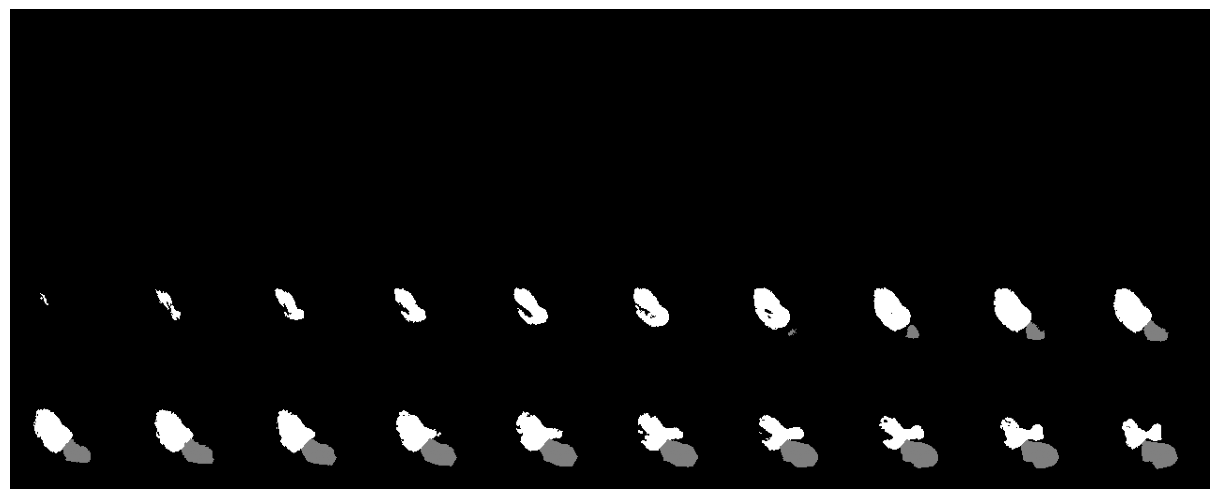

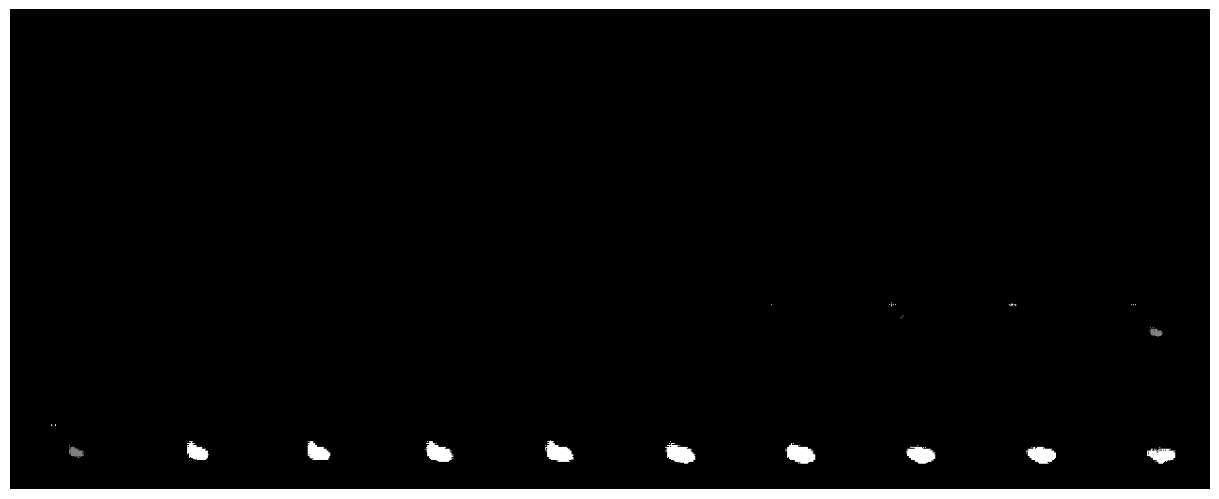

In [ ]:
for image, mask in test_batches.take(2):
  pred_mask = weighted_model.predict(image)
  # print(np.sum(pred_mask, axis=-1))
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  # pred_mask = pred_mask[..., tf.newaxis]
  # print(image.shape)
  # print(mask.shape)
  # print(pred_mask[0])
  plot_slices(4, 10, 128, 128, mask[0][:,:,:40])
  plot_slices(4, 10, 128, 128, pred_mask[0][:,:,:40])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


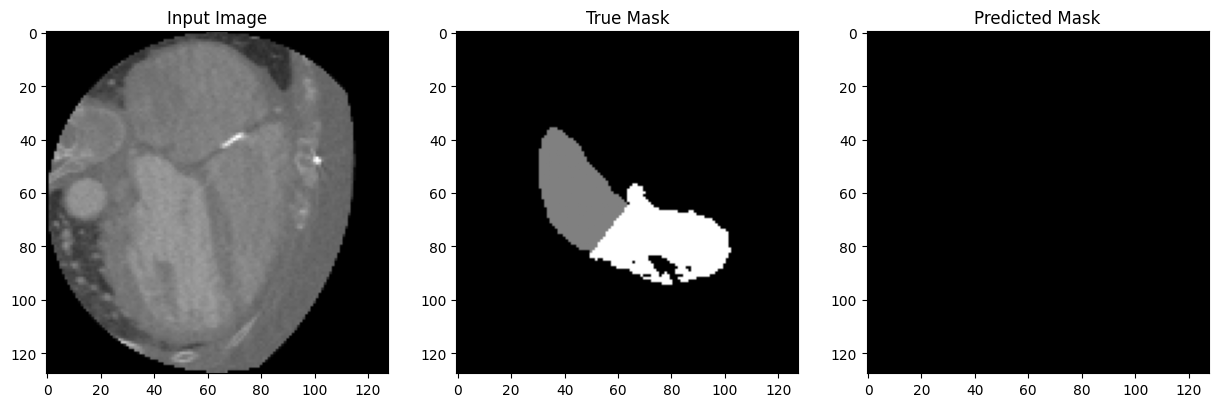

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


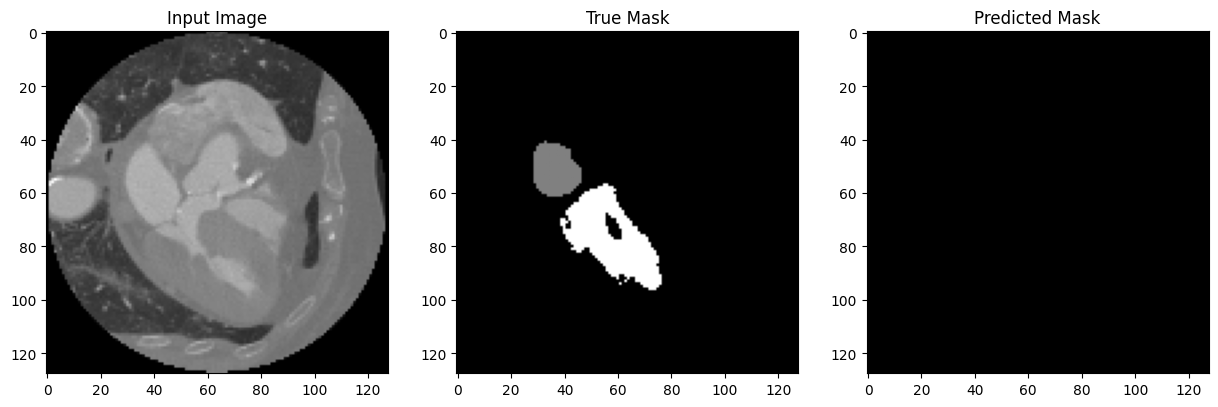

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


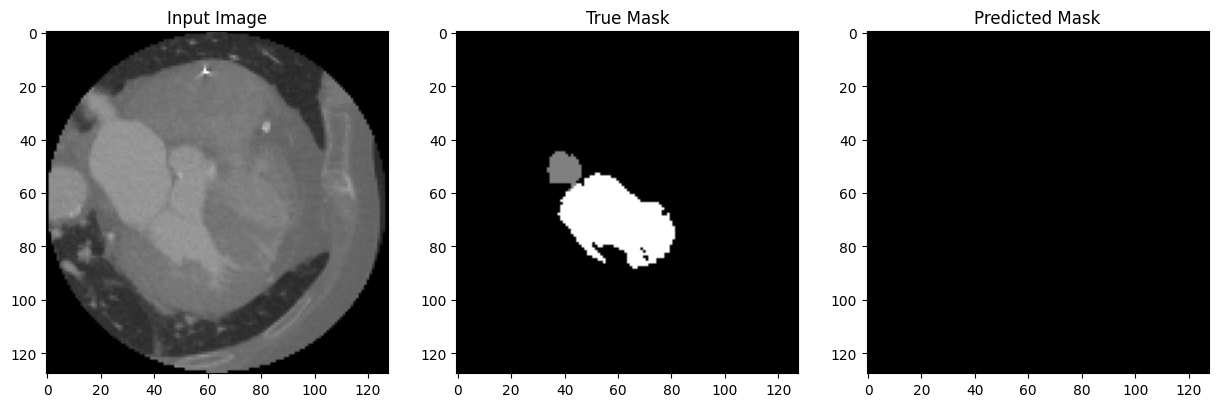

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
n_classes = 3
channels=3

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1,2,2]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(128, 128, 64, channels),
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

176606448/176606448 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      5,248 │ input_layer_43[0… │
│ (Conv3D)            │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │    110,656 │ block1_conv1[0][… │
│ (Conv3D)            │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │    221,312 │ block1_pool[0][0] │
│ (Conv3D)            │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    442,496 │ block2_conv1[0][… │
│ (Conv3D)            │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling3D)      │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    884,992 │ block2_pool[0][0] │
│ (Conv3D)            │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │  1,769,728 │ block3_conv1[0][… │
│ (Conv3D)            │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │  1,769,728 │ block3_conv2[0][… │
│ (Conv3D)            │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16, 8, │          0 │ block3_conv3[0][… │
│ (MaxPooling3D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16, 8, │  3,539,456 │ block3_pool[0][0] │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16, 8, │  7,078,400 │ block4_conv1[0][… │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16, 8, │  7,078,400 │ block4_conv2[0][… │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 4,   │          0 │ block4_conv3[0][… │
│ (MaxPooling3D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 4,   │  7,078,400 │ block4_pool[0][0] │
│ (Conv3D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 4,   │  7,078,400 │ block5_conv1[0][

 Total params: 71,233,107 (271.73 MB)

 Trainable params: 71,229,075 (271.72 MB)

 Non-trainable params: 4,032 (15.75 KB)

None


In [ ]:
history=model.fit(train_batches,
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          verbose=1,
          validation_data=test_batches)

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-202-195054102570>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 4169892544 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_119160]

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=lambda y_true, y_pred: dice_loss(y_true, y_pred, num_classes=3),
              metrics=['accuracy'])

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.input_shape, model.output_shape

((None, 128, 128, 64, 3), (None, 128, 128, 64, 3))

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 2
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 128, 128, 64, 3), output.shape=(None, 128, 128, 64, 3)

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((ed_images, ed_masks))
test_loader = tf.data.Dataset.from_tensor_slices((es_images, es_masks))

In [ ]:
# Augment the on the fly during training.
train_batches = (
    train_loader
    .cache()
    .shuffle(BUFFER_SIZE)
    .map(train_preprocessing)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Only rescale.
test_batches = (
    test_loader
    .map(test_preprocessing)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
OUTPUT_CLASSES = 3

weighted_model = unet_model(OUTPUT_CLASSES)
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.96
)
weighted_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

weighted_model_history = weighted_model.fit(train_batches.map(add_sample_weights),
                                            epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_steps=VALIDATION_STEPS,
                                            validation_data=test_batches)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 573ms/step - accuracy: 0.7568 - loss: 0.1272 - val_accuracy: 0.9541 - val_loss: 0.4187
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step - accuracy: 0.9654 - loss: 0.0471 - val_accuracy: 0.9387 - val_loss: 0.3063
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step - accuracy: 0.9651 - loss: 0.0330 - val_accuracy: 0.9445 - val_loss: 0.1853
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step - accuracy: 0.9708 - loss: 0.0268 - val_accuracy: 0.9520 - val_loss: 0.1469
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.9730 - loss: 0.0226 - val_accuracy: 0.9483 - val_loss: 0.1479
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - accuracy: 0.9743 - loss: 0.0184 - val_accuracy: 0.9436 - val_loss: 0.1677
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 518ms/step - accuracy: 0.9786 - loss: 0.0155 - val_accuracy: 0.9513 - val_loss: 0.1415
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.9821 - loss: 0.0136 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


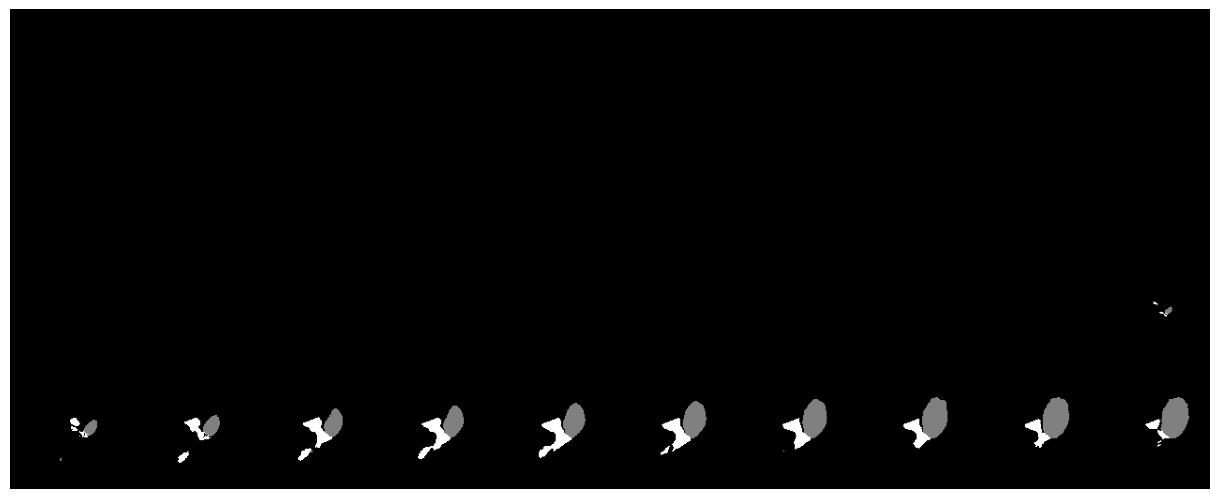

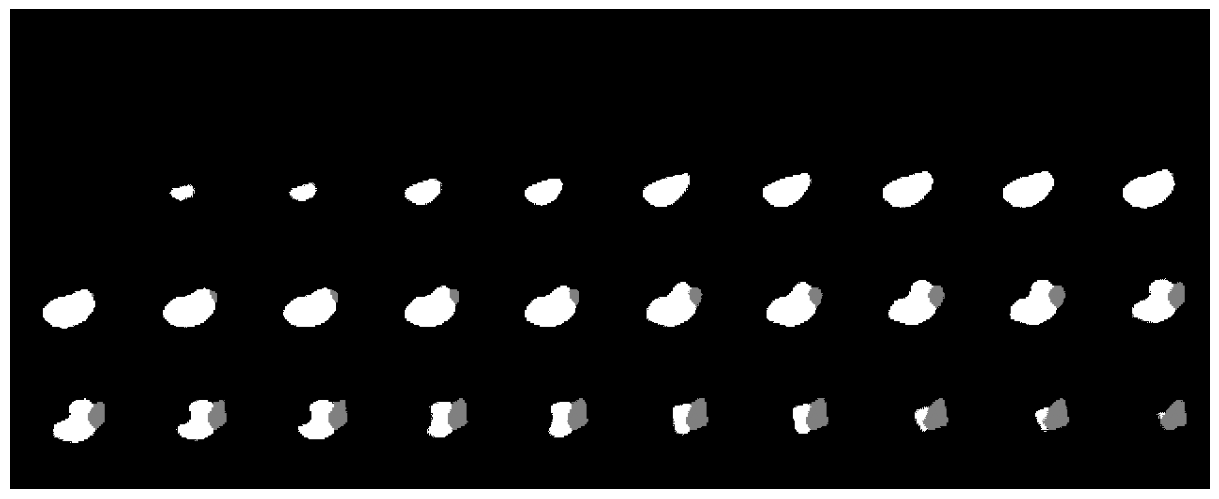

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


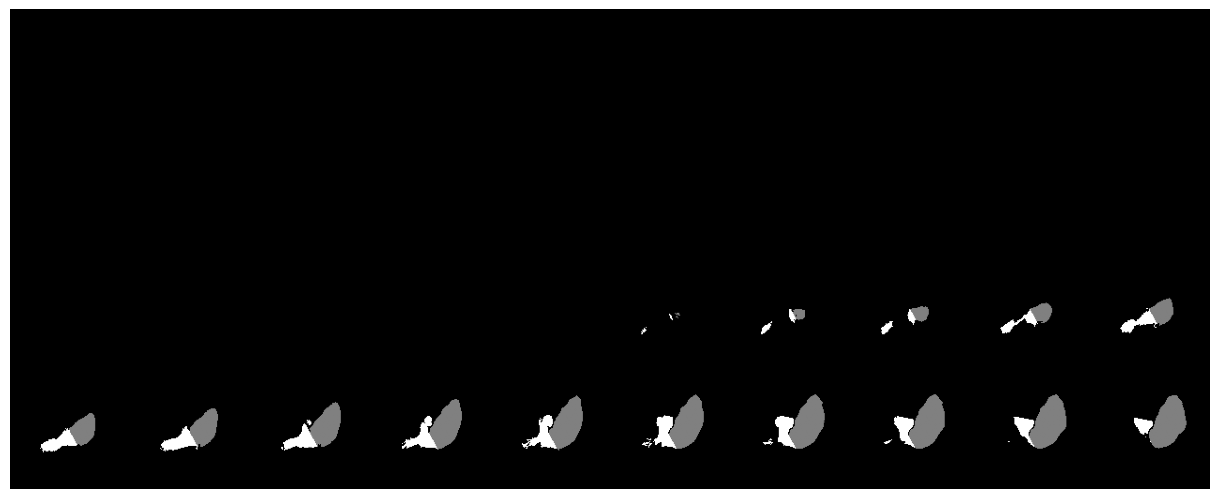

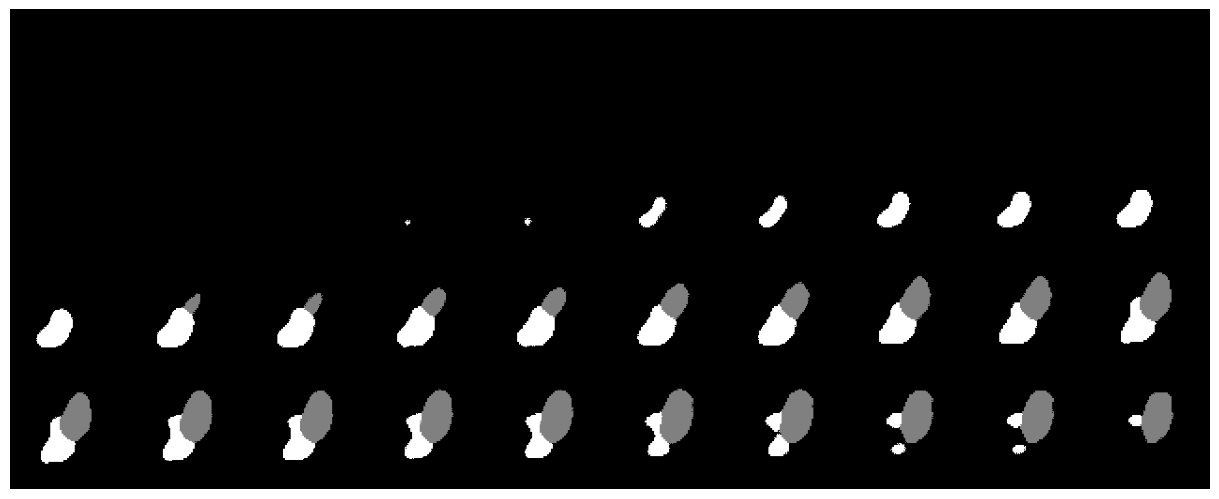

In [ ]:
for image, mask in test_batches.take(2):
  pred_mask = weighted_model.predict(image)
  # print(np.sum(pred_mask, axis=-1))
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  # pred_mask = pred_mask[..., tf.newaxis]
  # print(image.shape)
  # print(mask.shape)
  # print(pred_mask[0])
  plot_slices(4, 10, 128, 128, mask[0][:,:,:40])
  plot_slices(4, 10, 128, 128, pred_mask[0][:,:,:40])